# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


# **Modelo con no normalizados**


In [2]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
df.info()
df= df[['latitud', 'longitud']]
#df = df.sample(n=30000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  int64  
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  int64  
 5   conducta        492988 non-null  int64  
 6   modalidad       492988 non-null  int64  
 7   arma_medio      492988 non-null  int64  
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  int64  
 10  categoria_bien  492988 non-null  int64  
 11  día             492988 non-null  int64  
 12  mes             492988 non-null  int64  
 13  zona            492988 non-null  int64  
 14  rango_hora      492988 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 56.4 MB


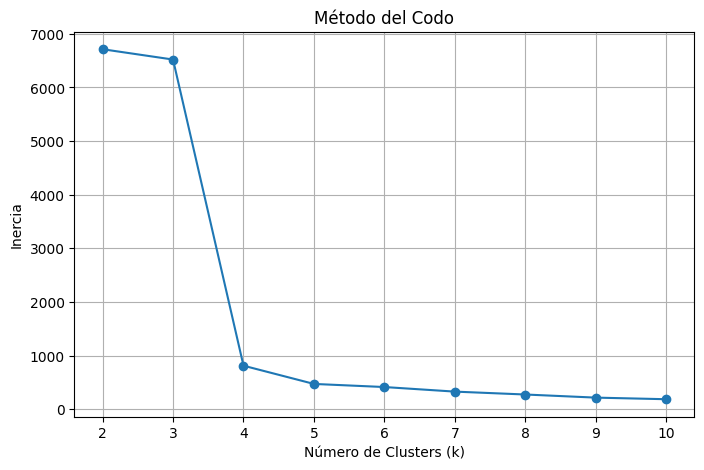

In [8]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

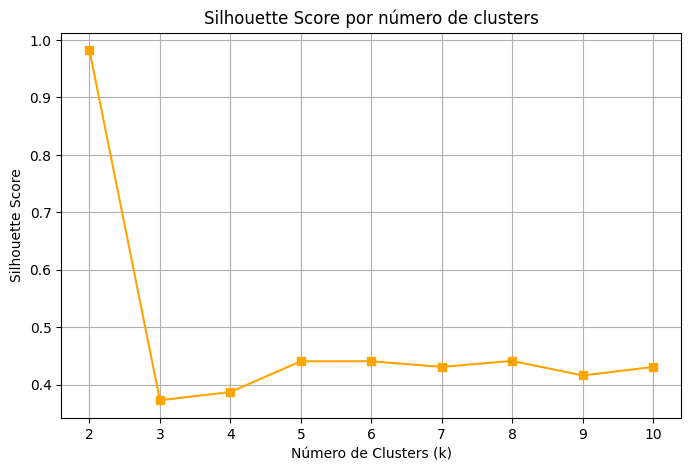

In [10]:
# silhouette scores
# ==============================================================================
df_sample = df.sample(n=25000, random_state=42)
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_sample)
    silhouette_scores.append(silhouette_score(df_sample, labels))

# Graficar silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [16]:
# Modelado
# ==============================================================================

# Kluste
k_optimo = 4
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
df['cluster'] = kmeans_final.fit_predict(df)

# Análisis de los clusters
cluster_summary = df.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Resumen por cluster:
          latitud   longitud
cluster                     
0        6.276723 -75.571178
1        6.235324 -75.578958
2        6.257663  75.607180
3        5.605000  -0.000679


In [18]:
# visualizacion
# ==============================================================================

df_sample = df.sample(n=100000, random_state=42)
df_dots = df_sample[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa





Output hidden; open in https://colab.research.google.com to view.